UE20CS332 - Algorithms for Information Retrieval and Intelligent Web

Assignment -2
(Implemention of a Recommender system.)


Corpus Used: Movies and Its Ratings


Team:
PES1UG20CS_563_568_634_653


**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
!pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Uploading Datasets**

In [ ]:
# Load the data
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

# Explore the data
movies.head()
ratings.head()


userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

**Exploratory Analysis on the Datasets**

a) Shape of the Dataset

In [ ]:
movies.shape

(9125, 3)

In [ ]:
ratings.shape

(100004, 4)

b) Describing Dataset

In [ ]:
movies.describe()

movieId
count    9125.000000
mean    31123.291836
std     40782.633604
min         1.000000
25%      2850.000000
50%      6290.000000
75%     56274.000000
max    164979.000000

In [ ]:
ratings.describe()

userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


c) Handling Missing Values

In [ ]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

d) Data Visualization

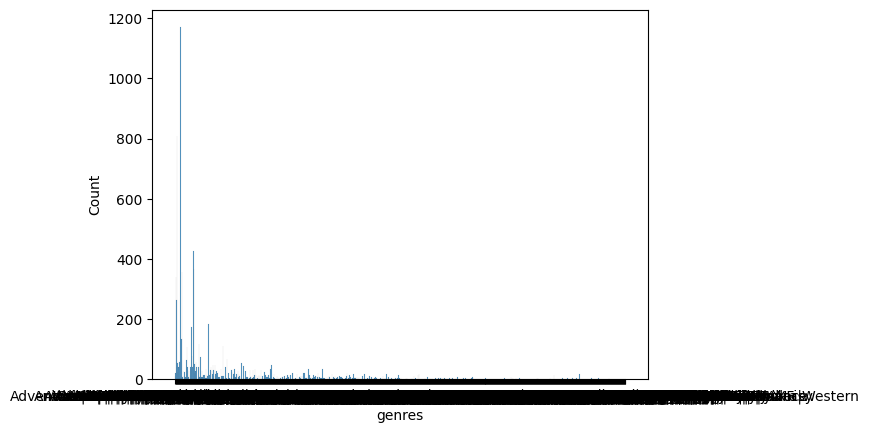

In [ ]:
# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
  
sns.histplot(x='genres', data=movies, )
plt.show()

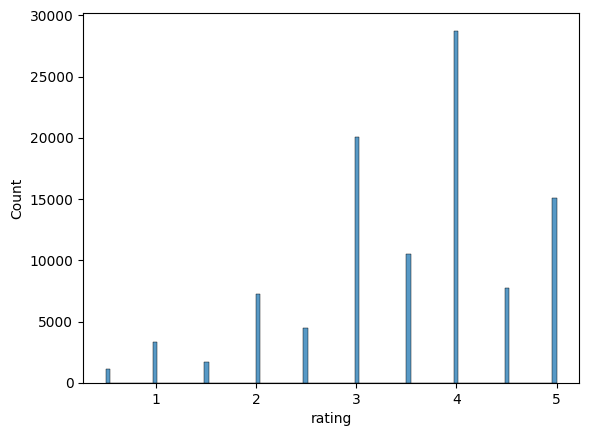

In [ ]:

# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
  
sns.histplot(x='rating', data=ratings, )
plt.show()

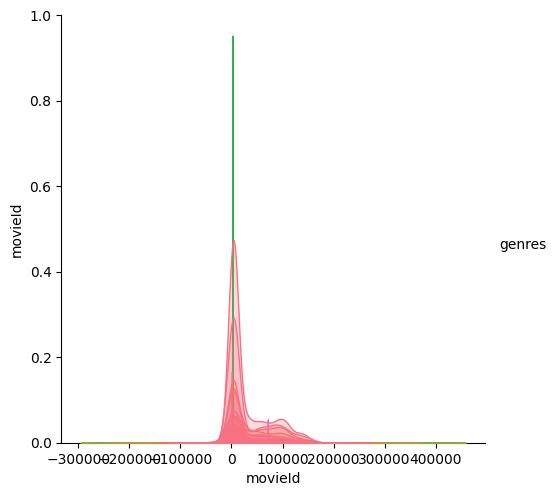

In [ ]:
# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
  
  
sns.pairplot(movies, hue='genres', height=5)

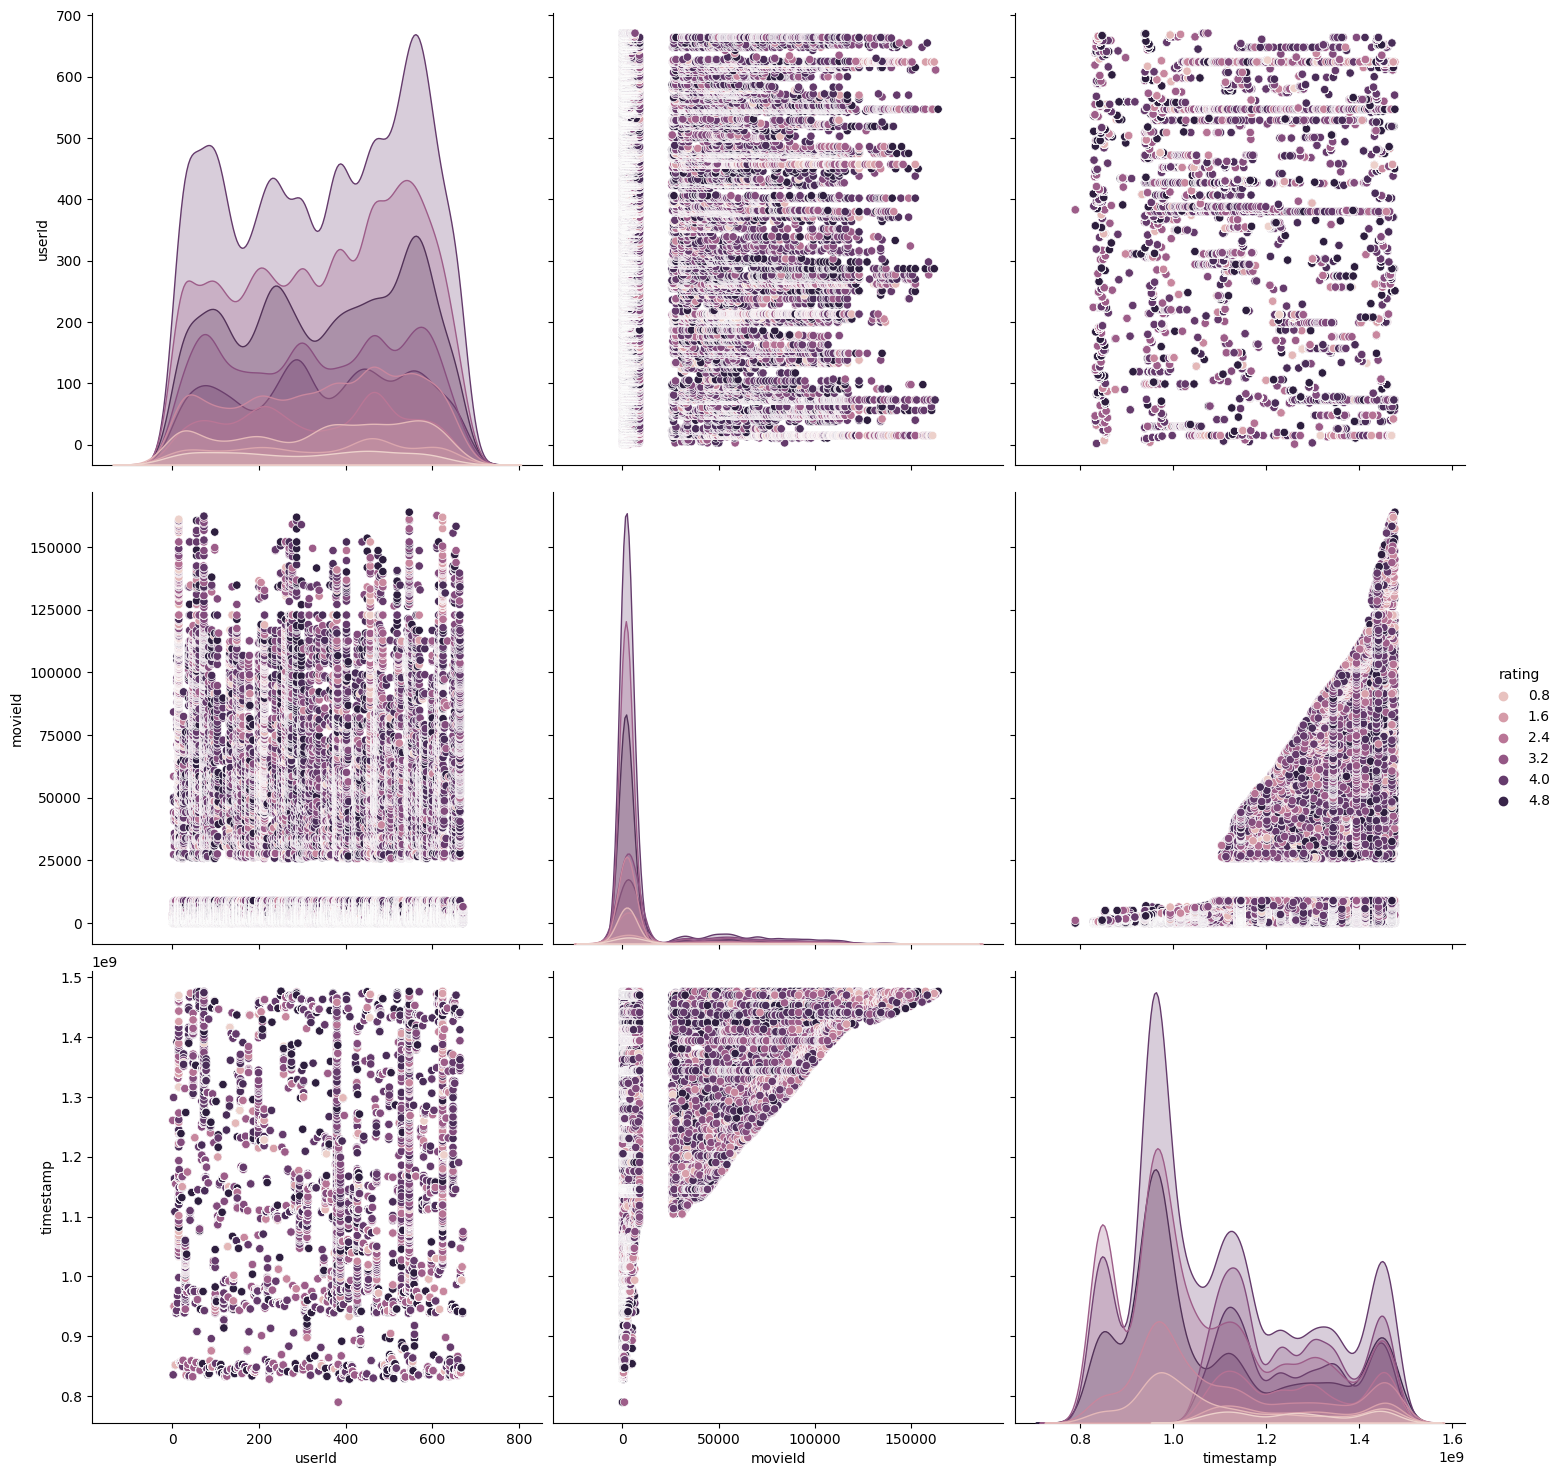

In [ ]:
# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
  
  
sns.pairplot(ratings, hue='rating', height=5)

e) Handling Outliers

In [ ]:
# Position of the Outlier
import numpy as np
print(np.where(movies['movieId']>10))

(array([  10,   11,   12, ..., 9122, 9123, 9124]),)


<Axes: xlabel='movieId'>

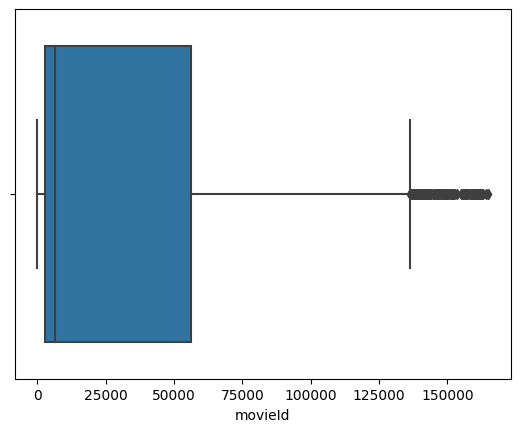

In [ ]:
# importing packages
import seaborn as sns
import matplotlib.pyplot as plt
  
# Load the dataset
movies = pd.read_csv('/content/movies.csv')
  
sns.boxplot(x='movieId', data=movies)

Old Shape:  (9125, 3)
New Shape:  (8932, 3)


<ipython-input-95-9e3cfea1a0f2>:11: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(movies['movieId'], 25,
<ipython-input-95-9e3cfea1a0f2>:14: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(movies['movieId'], 75,


<Axes: xlabel='movieId'>

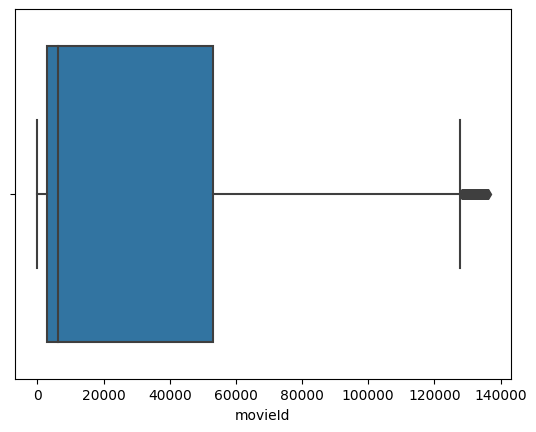

In [ ]:

# Importing
import sklearn

import pandas as pd
import seaborn as sns
  
# Load the dataset
movies = pd.read_csv('/content/movies.csv')
  
# IQR
Q1 = np.percentile(movies['movieId'], 25,
                interpolation = 'midpoint')
  
Q3 = np.percentile(movies['movieId'], 75,
                interpolation = 'midpoint')
IQR = Q3 - Q1
  
print("Old Shape: ", movies.shape)
  
# Upper bound
upper = np.where(movies['movieId'] >= (Q3+1.5*IQR))
  
# Lower bound
lower = np.where(movies['movieId'] <= (Q1-1.5*IQR))
  
# Removing the Outliers
movies.drop(upper[0], inplace = True)
movies.drop(lower[0], inplace = True)
  
print("New Shape: ", movies.shape)
  
sns.boxplot(x='movieId', data=movies)

**Pre-process the data**

In [ ]:
# Merge the two dataframes
data = pd.merge(movies, ratings, on='movieId')

In [ ]:
data.head()

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       7     3.0   851866703  
1       9     4.0   938629179  
2      13     5.0  1331380058  
3      15     2.0   997938310  
4      19     3.0   855190091

In [ ]:
# Group the data by movie title and calculate the average rating
ratings_mean = data.groupby(['title'])['rating'].mean().reset_index()

# Merge the ratings_mean dataframe with the original movies dataframe
movies = pd.merge(movies, ratings_mean, on='title')

# Create a new column 'rating_weight' to factor in the number of ratings
#movies['rating_weight'] = movies['rating']*movies['vote_count']

# Create a new dataframe with selected columns
movie_features = movies[['movieId', 'title', 'genres']]


**Neighbourhood Based Collaborative Filtering**

In [ ]:
# Create a pivot table with user ratings for each movie
user_ratings = data.pivot_table(index='userId', columns='title', values='rating')

# Replace missing values with 0
user_ratings = user_ratings.fillna(0)

# Calculate the similarity between movies using cosine similarity
movie_similarity = cosine_similarity(user_ratings.T)

# Create a function to get the top 10 similar movies
def get_similar_movies(movie_name, movie_similarity):
    idx = movies[movies['title']==movie_name].index[0]
    similar_movies = list(enumerate(movie_similarity[idx]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    similar_movies = similar_movies[1:11]
    movie_indices = [i[0] for i in similar_movies]
    return movies['title'].iloc[movie_indices]

# Test the function
get_similar_movies('Toy Story (1995)', movie_similarity)


239                  Major Payne (1995)
282                     Stargate (1994)
250               Miami Rhapsody (1995)
503     Welcome to the Dollhouse (1995)
331                    Mask, The (1994)
332                     Maverick (1994)
373                   Blown Away (1994)
1460                    Insomnia (1997)
370        Beverly Hills Cop III (1994)
19                   Money Train (1995)
Name: title, dtype: object

**Content Based Recommendation**

In [ ]:
# Define the CountVectorizer object
vectorizer = CountVectorizer()

# Create a sparse matrix of word counts for each movie genre
genre_matrix = vectorizer.fit_transform(movies['genres'])

# Calculate the similarity between movies using cosine similarity
genre_similarity = cosine_similarity(genre_matrix)

# Create a function to get the top 10 similar movies
def get_similar_movies_by_genre(movieID, genre_similarity):
    idx = movies[movies['title']==movieID].index[0]
    similar_movies = list(enumerate(genre_similarity[idx]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    similar_movies = similar_movies[1:11]
    movie_indices = [i[0] for i in similar_movies]
    return movies['title'].iloc[movie_indices]
    
# Test the function
get_similar_movies_by_genre('Toy Story (1995)', genre_similarity)


1815                                          Antz (1998)
2506                                   Toy Story 2 (1999)
3004       Adventures of Rocky and Bullwinkle, The (2000)
3218                     Emperor's New Groove, The (2000)
3804                                Monsters, Inc. (2001)
6685                               Shrek the Third (2007)
7123                       Tale of Despereaux, The (2008)
7920    Asterix and the Vikings (Astérix et les Viking...
8338                                         Turbo (2013)
8640                                Boxtrolls, The (2014)
Name: title, dtype: object

**Analysis:**

We can analyze the results by manually inspecting the recommended movies and checking if they are similar to the input movie in terms of genre and other characteristics. For example, if we input 'Toy Story (1999)', we might expect to see recommendations for other animated children's movies with similar themes and tones, such as 'Shrek the Third (2007)' or 'Antz (1998)'. We can also calculate some evaluation metrics to assess the performance of the recommender system.

**Evaluation Metrics:**

In [ ]:
# Define the ground truth movies for a sample user
ground_truth = ['Toy Story (1995)', 'Antz (1998)', 'Shrek the Third (2007)', 'Tale of Despereaux, The (2008)']

# Get the top 10 recommended movies for the user
recommended_movies = get_similar_movies_by_genre('Toy Story (1995)', genre_similarity)

# Calculate precision and recall
num_relevant = len(set(ground_truth).intersection(set(recommended_movies)))
precision = num_relevant / len(recommended_movies)
recall = num_relevant / len(ground_truth)

# Print the results
print('Precision:', precision)
print('Recall:', recall)


Precision: 0.3
Recall: 0.75
